# bitumite
Bitumite - Structural Model Construction with 80-95% Carbon content [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liuhaodong9/GenCoal/blob/main/docs/source/examples/bitumite.ipynb)

### Install the package from pip (skip this step if the package is already installed)

In [1]:
# ! pip install clipirmol

### Import package

In [2]:
# set coal path (optional if installed via pip)

import sys, os
import json

project_path = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
print(project_path)
sys.path.insert(0, project_path)
sys.path.insert(0, project_path)

# import python file from coal file directory
import coal.utils as ut
import coal.CoalGenerator as gen
import coal.ClipIRMol as clipirmol


/home/liuhaodong/CoalModel


### ad to daf in elemental proportion

In [3]:
C_ad = 79.38  # 碳
N_ad = 1.43   # 氮
H_ad = 4.53  # 氢
S_ad = 0.59  # 硫
M = 0.6695   # 水分
A = 9.6252   # 灰分

C_daf, N_daf, H_daf, S_daf, O_daf = ut.ad2daf(C_ad, N_ad, H_ad, S_ad, M, A)
print(f"C_daf, N_daf, H_daf, S_daf, O_daf = {C_daf, N_daf, H_daf, S_daf, O_daf}")

O_ad= 3.775299999999987
C_daf, N_daf, H_daf, S_daf, O_daf = (88.4897547859491, 1.5941087092958834, 5.049868848328918, 0.6577091877514484, 4.208558468674635)


### Import elemental proportion

In [4]:
# daf 	C	H	N	S	O
# 主2	89.76	4.74	1.45	1.78	2.27
# 主3	88.51	5.03	1.54	1.09	3.83
# 肥2	88.48	5.20	1.57	0.45	4.30
# 肥3	87.22	5.03	1.51	2.08	4.16
# 瘦2	90.34	4.45	1.55	1.00	2.66
# 瘦4	91.59	4.41	1.62	0.43	1.95
# FS
ele_ratio = {
        "C": C_daf,
        "H": H_daf,
        "N": N_daf,
        "S": S_daf,
        "O": O_daf
    }
print(ele_ratio)

{'C': 88.4897547859491, 'H': 5.049868848328918, 'N': 1.5941087092958834, 'S': 0.6577091877514484, 'O': 4.208558468674635}


### Import CSV table of <sup>13</sup>C NMR

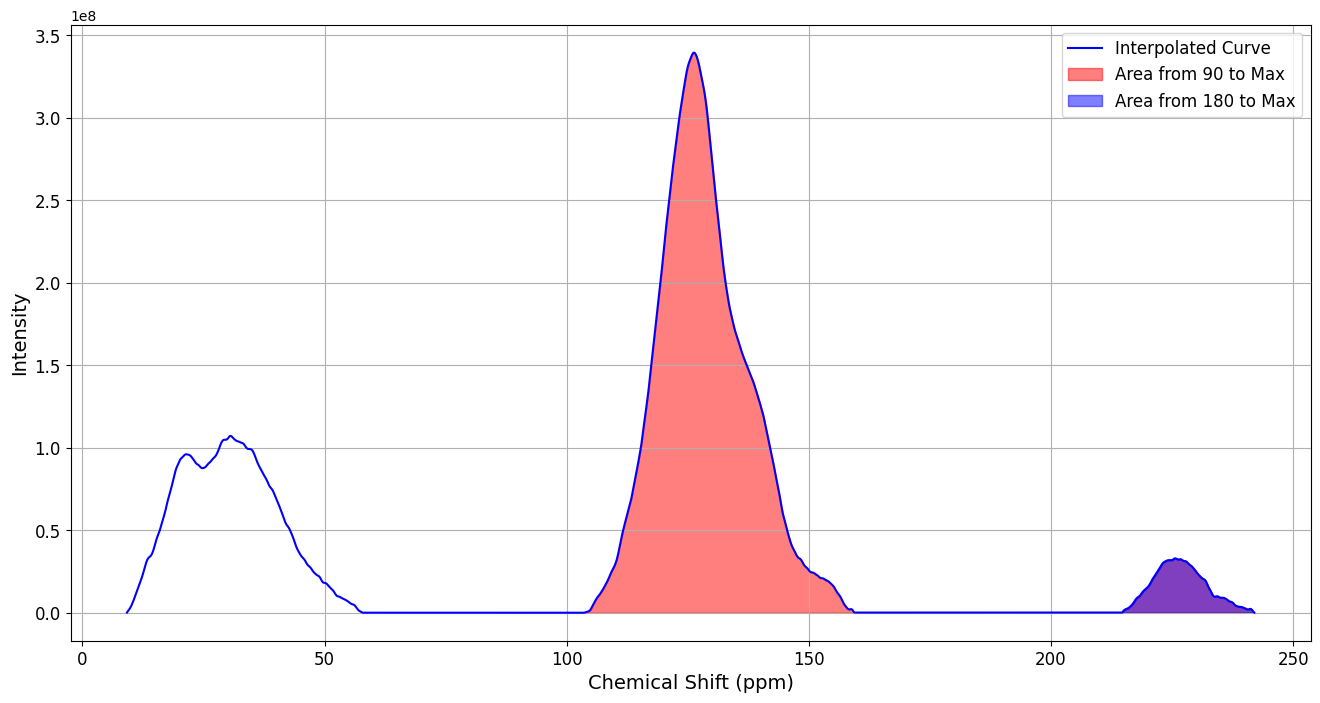

ppm>90 = 0.72 ,ppm>180 = 0.044


In [5]:
NMR_file_path = "bitumite/ZCD-NMR.csv"
C90, C180 = ut.calculate_C90_C180(NMR_file_path)
print("ppm>90 =", C90, ",ppm>180 =", C180)

### Import CSV table of IR

In [6]:
# 输入红外文件
IR_file_path = 'bitumite/ZCD-IR.CSV'



# 获取分子数据
retrieved_molecules = clipirmol.retrieve_small_molecules(IR_file_path)

# 打印红外光谱检索出来的小分子
# smiles_and_scores = clipirmol.convert_data_to_smiles_scores(retrieved_molecules)
# clipirmol.display_molecules(smiles_and_scores)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# 从retrieved_molecules获取SMILES字符串
selected_smiles = [mol['smiles'] for mol in retrieved_molecules]
extended_smiles_list = []

# 使用connect_rings_C4函数扩展这些SMILES字符串
for smiles in selected_smiles:
    extended_smiles = clipirmol.connect_rings_C4(smiles)
    extended_smiles = clipirmol.connect_rings_C4(extended_smiles)  # 再次扩展
    extended_smiles_list.append(extended_smiles)

# 更新updated_predicted_smiles_and_scores
updated_predicted_smiles_and_scores = [[(mol['smiles'], mol['score']) for mol in retrieved_molecules]]
for i, (smiles, score) in enumerate(updated_predicted_smiles_and_scores[0]):
    extended_smiles = extended_smiles_list[i]
    updated_predicted_smiles_and_scores[0][i] = (extended_smiles, score)

# clipirmol.display_molecules(updated_predicted_smiles_and_scores[0])

# 过滤SMILES
new_smiles_and_scores = clipirmol.filter_smiles_and_scores(updated_predicted_smiles_and_scores)
new_smiles_and_scores = [new_smiles_and_scores]

# 显示过滤后的图像
clipirmol.display_molecules(new_smiles_and_scores[0]) 

### input molecule scale

In [ ]:
coal_smiles_list = [i[0] for i in new_smiles_and_scores[0]]

# 指定 JSON 文件名
filename = 'bitumite.json'

# 读取现有的 JSON 数据
with open(filename, 'r') as file:
    data = json.load(file)

data["C_atom"] = 300

### input extra carbonyl, hydroxyl

In [ ]:
carbonyl, hydroxyl = ut.recommended_carbonyl_hydroxyl(data["C_atom"], ele_ratio)
print(f"The number of O in carbonyl and hydroxyl should be {carbonyl} and {hydroxyl}")
carbonyl, hydroxyl = 0, 0

### import bitumite.json as input

In [ ]:
# 更新 coal_smiles_list 的值
data['coal_smiles_list'] = coal_smiles_list
data['ele_ratio'] = ele_ratio
data['C90'] = C90
data['C180'] = C180
data['type'] = "bitumite"



In [ ]:
# 将更新后的数据写回 JSON 文件
with open(filename, 'w') as file:
    json.dump(data, file, indent=4)

print("Update input information successfully!")

In [ ]:
## 读文件
data = ut.read_json('bitumite.json')
# job=15
# 600 13min depth=30
# 700 1h6min depth=40
# 800 5h26min depth=40
generator = gen.CoalGenerator(data)
current_smiles = generator.run()

### checking revised molecule model

In [ ]:
ratio = ut.calculate_unsaturated_carbon_ratio("CC1CCc(c(C1=O)cc2)c3c2c4c(Cc(cc5)c(C4)c6c5c7c(C(CC(C7=O)C8CCc(cn9)c(C8=O)c%10c9c%11c(C(c(c%12)c(C%11)cc%13c%12c%14c(CCC(C%14=O)C%15CCC(C(C%15=O)C)c(cc%16)cc%17c%16c%18c(Cc(c(C%18)c(COC%19CCc(cc%20)c(C%19=O)c%21c%20cc%22c(Cc(c(C%22)cc%23)c%24c%23cccc%24C(C%25CCC(C(C%25C%26CCc(c(C%26=O)c%27c%28Cc(c%29)c(C%27)cc%30c%29c(CC%31CCC(C(C%31C)=O)C)cc%32c%30CCCC%32)c%33c%28cccc%33)=O)OCC%34CCCCC%34c%35c(Cc(c(C%36)cc%37)c%38c%37ccc(C%39CCC(C(C%39C)=O)C)c%38)c%36ncc%35)C)c%21)n%40)c%41c%40c%42c(CCCC%42)cc%41)cc%17)cn%13)C)cc%10)C)nc6)cc3")
print("Unsatutated carbon rate of final coal model is", ratio)